# *BASECODE 작성*

* 가상환경 activate 후 lightgbm 설치
* conda install -c conda-forge lightgbm

In [2]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import random
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import log_loss

## 0. **데이터 로드**
* 훈련에 필요없는 index 컬럼 삭제
#### 변수
* train : `train.csv`
* test : `test.csv`

In [3]:
# 데이터 불러오기
train = pd.read_csv('./train.csv')
train = train.drop(['index'], axis=1)

test = pd.read_csv('./test.csv')
test = test.drop(['index'], axis=1)

submit = pd.read_csv('./sample_submission.csv')

### 데이터 전처리
http://www.dodomira.com/2016/10/20/how_to_eda/ 

링크 참고 

## 1. **데이터 셋 확인**

* 이전 EDA 코드 돌려봤기에 코드를 직접 합치지는 않았음

In [ ]:
train.info()
test.info()
display(train.head())

In [ ]:
# 각 유형 갯수 확인
count_type = [0, 0, 0] # object, int64, float64
for col in train.columns:
    if train[col].dtype == 'object':
        count_type[0] += 1
    elif train[col].dtype == 'int64':
        count_type[1] += 1
    elif train[col].dtype == 'float64':
        count_type[2] += 1
display(count_type)

#### object 8개, int64 7개 , float64 4개 있음.
-------------------------

## 2. **결측치 처리**
* 결측치는 직업 유형에만 존재함 -> 'unfilled'로 대체함. 
* 향후 '직업 유형의 결측치를 어떻게 해결할 것 인가' 고민이 필요함.

In [ ]:
test['occyp_type'].count

In [ ]:
test['occyp_type'].isnull().sum()

In [ ]:
# 결측치 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())

In [5]:
# 결측치 처리
print()
train['occyp_type'].fillna('unfilled', inplace=True) # 직업 유형 경우, 결측치가 많아서 따로 'unfilled' 라고 채움
test['occyp_type'].fillna('unfilled', inplace=True)
train.fillna('NAN', inplace=True) 
test.fillna('NAN', inplace=True)

# 확인
print('훈련데이터 결측치 합 \n', train.isnull().sum())
print('테스트데이터 결측치 합 \n', test.isnull().sum())


훈련데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
credit           0
dtype: int64
테스트데이터 결측치 합 
 gender           0
car              0
reality          0
child_num        0
income_total     0
income_type      0
edu_type         0
family_type      0
house_type       0
DAYS_BIRTH       0
DAYS_EMPLOYED    0
FLAG_MOBIL       0
work_phone       0
phone            0
email            0
occyp_type       0
family_size      0
begin_month      0
dtype: int64


## 3. **이상치 처리**
* 정수형, 실수형 데이터에서 이상치 찾아보고, 그에 맞게 처리하자.

In [ ]:
display(len(train.columns))
display((train.columns))

### **3-1. 각 컬럼 데이터 변환 and 이상치 처리**
* 정수/실수형 데이터를 가진 10개 컬럼 중 휴대전화/직장전화/가정용전화/이메일 보유여부는 이상치 없음. (1아니면 0이니깐)
* 이 외에 6개 컬럼들 하나씩 살펴보기
 * 6개: 자녀 수, 가족 규모, 연간 소득, 출생일, 업무 시작일, 신용카드 발급 월 
 * 또한 분석하기 용이하게 데이터 변경 (ex) 부호 변환 or 일 수를 나이로)

#### 1) 자녀 수
* 6명 이상의 자녀를 가진 사람은 5명으로 변경 -> 이유: test set에서 자녀의 수 max가 5 이기 때문. 

In [ ]:
print('train childnum unique:', train['child_num'].unique())

In [ ]:
print('test childnum unique:', test['child_num'].unique())

childnum unique: [0 1 2]


<AxesSubplot:xlabel='child_num'>

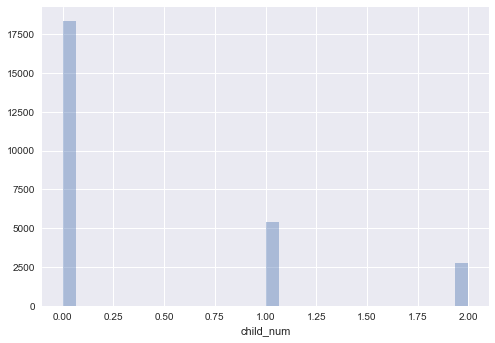

In [6]:
# 아이가 3명 이상인 데이터는 2로 변경
train.loc[train['child_num'] >= 3,'child_num']=2
print('childnum unique:', train['child_num'].unique())
sns.distplot(train['child_num'], kde=False, label='child_num')

#### 2) 가족 규모
* 1의 이유와 같이 최대 아이 숫자를 5로 했기 때문에 가족 규모의 최댓값도 7로 변경함

In [ ]:
print('train familysize unique:', train['family_size'].unique())

In [ ]:
print('test familysize unique:', test['family_size'].unique())

In [7]:
# 수정
train.loc[train['family_size'] >= 5,'family_size'] = 4

In [ ]:
print('train familysize unique:', train['family_size'].unique())
sns.distplot(train['family_size'], kde=False, label='family_size')

#### 3) 연간 소득
* 테스트 데이터에서도 박스플롯 밖의 값이 많이 있기에 박스플롯 밖의 값 제거 안하기로 결정

In [ ]:
sns.distplot(train['income_total'], kde=False, label='income_total')
fig, ax = plt.subplots(1, 2, figsize=(15,8))
sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("train Boxplot of income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("test Boxplot of income_total")

#### 4) 출생일 -> 나이
* 양수 변환 후 나이로 변환
* 정수형으로 변환

In [ ]:
def days_to_age(x):
    return (x*-1)/365

# train
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].apply(days_to_age)
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(train['DAYS_BIRTH'])

# test
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].apply(days_to_age)
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].astype({'DAYS_BIRTH':'int'})
display(test['DAYS_BIRTH'])

#### 5) 업무시작일 -> 업무 연차
* 양수 변환 후 연차로 변환
    * 단, 365243은 0연차로 변환
    * 135일 일한 사람과 0연차를 구분하기 위해서 0연차를 제외하고 모두 +1 해줌
* 정수형으로 변환

In [ ]:
def days_to_year(x):
    if x==365243 :
        return 0
    return (x*-1)/365+1

# train
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(days_to_year)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(train['DAYS_EMPLOYED'])

# test
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(days_to_year)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].astype({'DAYS_EMPLOYED':'int'})
display(test['DAYS_EMPLOYED'])

#### 6) 신용카드 발급 월

* 양수로 변환

In [ ]:
def minus(x):
    return x * -1

# train
train['begin_month'] = train['begin_month'].apply(minus)
display(train['begin_month'])

# test
test['begin_month'] = test['begin_month'].apply(minus)
display(test['begin_month'])

#### 7) 박스 플롯을 통한 이상치 확인
* 박스플롯

In [ ]:
train.info()

* 1) 신용카드 발급 월
* 2) 업무 연차
* 3) 나이
* 4) 연간 수입
 * 4개 컬럼에 대해 박스플롯 그려보기

In [ ]:
# 신용카드 발급 월의 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["begin_month"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's begin_month")

sns.boxplot(y=test["begin_month"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's begin_month")

In [ ]:
# 나이에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_BIRTH"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_BIRTH")

sns.boxplot(y=test["DAYS_BIRTH"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_BIRTH")

In [ ]:
# 연간 수입에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["income_total"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's income_total")

sns.boxplot(y=test["income_total"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's income_total")

In [ ]:
# 업무 연차에 대한 박스플롯
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["DAYS_EMPLOYED"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of train's DAYS_EMPLOYED")

sns.boxplot(y=test["DAYS_EMPLOYED"],data=test, ax=ax[1])
ax[1].set_title("Boxplot of test's DAYS_EMPLOYED")

In [ ]:
# child_num, family_size
fig, ax = plt.subplots(1, 2, figsize=(15,8))

sns.boxplot(y=train["child_num"],data=train, ax=ax[0])
ax[0].set_title("Boxplot of child_num")

sns.boxplot(y=train["family_size"],data=train, ax=ax[1])
ax[1].set_title("Boxplot of family_size")

#### 8) 상관관계
* 범주형과 수치형 상관관계 확인 - https://dodonam.tistory.com/217

In [ ]:
#상관관계를 확인
sns.set(rc={'figure.figsize':(14,8)})
corr = train.corr()
sns.heatmap(corr, cmap='coolwarm_r')

In [ ]:
# 다중 공선성 확인
list_numeric = ["child_num", "income_total", "DAYS_BIRTH", "DAYS_EMPLOYED", "family_size", "begin_month"]
sns.heatmap(train[list_numeric].corr(), annot = True, fmt = ".2f")
plt.show()

In [ ]:
#상관관계 수치로 확인
# 종속변수('Class')와의 상관관계
Corr = train.corr()
IF = Corr['credit'].sort_values().to_frame()
display(IF.head(5))
print(IF)

* 신용도와 가장 상관관계가 높은 컬럼은 "begin_month" 이나 0.147에 불과함

#### 9) 회귀분석 그래프

In [ ]:
# 9-1. 연차와 연간 소득의 회귀분석 그래프
# 연차가 낮은데 소득이 굉장히 많은 경우는 제거해도 좋을 듯
sns.lmplot(x="DAYS_EMPLOYED", y="income_total", data=train, line_kws={'color':"red"})

## 4. **Feature Engineering** - 여기에 정규화 포함시켜야 할듯요!

* 수치형 컬럼은 기존 데이터 분포와 비슷하고, 어느정도 일정한 범위를 갖게 정규화해야함
* 각 컬럼마다 동일한 스케일러 적용할 필요는 없음. 
* [다른 스케일러 적용한 사례- 블로그](https://lsjsj92.tistory.com/555?category=853217)

### 4-1. 범주형 데이터 one-hot encoding, label encoding
* object (범주형)은 원핫인코딩 하기.
    * 단, occyp_type은 라벨 인코딩.
* 범주형 데이터를 가지는 변수 확인 (dtype가 object)
* gender(2), car(2), reality(2), income_type(5), edu_type(5), family_type(5), house_type(6), occyp_type(18)

In [8]:
# object 객체를 가지는 변수(열) 확인
object_col = []
for col in train.columns:
    if train[col].dtype == 'object' : # and col!='occyp_type': # 변수가 18개인 occyp_type만 제외
        object_col.append(col)
display(object_col)

['gender',
 'car',
 'reality',
 'income_type',
 'edu_type',
 'family_type',
 'house_type',
 'occyp_type']

In [ ]:
print(train['occyp_type'].unique())
(len(train['occyp_type'].unique()))

#### 4-1-1. train의 원핫인코딩, 라벨인코딩

In [9]:
# occyp_type을 제외한 모든 object객체 열을 onehot encoding

enc = OneHotEncoder()
enc.fit(train.loc[:,object_col])

train_onehot_df = pd.DataFrame(enc.transform(train.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
train.drop(object_col, axis=1, inplace=True)
train = pd.concat([train, train_onehot_df], axis=1)

In [ ]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# train['occyp_type']=label_encoder.fit_transform(train['occyp_type'])

In [ ]:
# 인코딩 확인

display(train.head(5))
print(train.columns)
train.info()

#### 4-1-2. test의 원핫인코딩, 라벨인코딩

In [10]:
# occyp_type을 제외한 모든 object객체 열을  onehot encoding
enc = OneHotEncoder()
enc.fit(test.loc[:,object_col])

test_onehot_df = pd.DataFrame(enc.transform(test.loc[:,object_col]).toarray(), 
             columns=enc.get_feature_names(object_col))
test.drop(object_col, axis=1, inplace=True)
test = pd.concat([test, test_onehot_df], axis=1)

In [ ]:
# occyp_type을 label encoding

# label_encoder=preprocessing.LabelEncoder()
# test['occyp_type']=label_encoder.fit_transform(test['occyp_type'])

In [ ]:
# 인코딩 확인

display(test.head(5))
print(test.columns)
test.info()

### 4-2. 데이터 정규화

#### 정규화 전 분포도
* 수치형 데이터만

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(train['child_num'], ax=ax[0][0])
sns.distplot(train['income_total'], ax=ax[0][1])

sns.distplot(train['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(train['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(train['family_size'], ax=ax[2][0])
sns.distplot(train['begin_month'], ax=ax[2][1])

#### 4-2-1. MinMaxScaler

In [11]:
from sklearn.preprocessing import MinMaxScaler

MinMaxScaler_data = train[train.columns.difference(['credit'])].copy()

minMaxScaler = MinMaxScaler()
print(minMaxScaler.fit(MinMaxScaler_data))
train_data_minMaxScaled = minMaxScaler.transform(MinMaxScaler_data)

# MinMaxScaler_data - MinMaxScaler적용한 데이터 프레임
index = 0
for col in MinMaxScaler_data.columns :
    MinMaxScaler_data[col] = train_data_minMaxScaled[:,index]
    index = index + 1
display(MinMaxScaler_data)

MinMaxScaler()


,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,begin_month,car_N,car_Y,child_num,edu_type_Academic degree,edu_type_Higher education,edu_type_Incomplete higher,...,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Waiters/barmen staff,occyp_type_unfilled,phone,reality_N,reality_Y,work_phone
0,0.644982,0.028885,0.0,0.900000,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.789362,0.037204,0.0,0.916667,1.0,0.0,0.5,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.347624,0.029607,0.0,0.633333,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,0.576833,0.035755,0.0,0.383333,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.579756,0.035721,0.0,0.566667,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,0.749298,0.036038,0.0,0.966667,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26453,0.565197,0.034749,0.0,0.216667,1.0,0.0,0.5,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
26454,0.863759,0.035957,0.0,0.583333,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
26455,0.860148,0.040965,0.0,0.016667,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [ ]:
# MinMaxScaler 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MinMaxScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MinMaxScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MinMaxScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MinMaxScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MinMaxScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MinMaxScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-2 MaxAbsScaler

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

MaxAbsScaler_data = train[train.columns.difference(['credit'])].copy()

maxAbsScaler = MaxAbsScaler()
print(maxAbsScaler.fit(MaxAbsScaler_data))
train_data_maxAbsScaled = maxAbsScaler.transform(MaxAbsScaler_data)

# MaxAbsScaler_data - MaxAbsScaler 적용한 데이터 프레임
index = 0
for col in MaxAbsScaler_data.columns :
    MaxAbsScaler_data[col] = train_data_maxAbsScaled[:,index]
    index = index + 1
display(MaxAbsScaler_data)

In [ ]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(MaxAbsScaler_data['child_num'], ax=ax[0][0])
sns.distplot(MaxAbsScaler_data['income_total'], ax=ax[0][1])

sns.distplot(MaxAbsScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(MaxAbsScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(MaxAbsScaler_data['family_size'], ax=ax[2][0])
sns.distplot(MaxAbsScaler_data['begin_month'], ax=ax[2][1])


MinMaxScaler_data


#### 4-2-3 StandardScaler

In [ ]:
from sklearn.preprocessing import StandardScaler

StandardScaler_data = train[train.columns.difference(['credit'])].copy()

standardScaler = StandardScaler()
print(standardScaler.fit(StandardScaler_data))
train_data_standardScaled = standardScaler.transform(StandardScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in StandardScaler_data.columns :
    StandardScaler_data[col] = train_data_standardScaled[:,index]
    index = index + 1
display(StandardScaler_data)

In [ ]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(StandardScaler_data['child_num'], ax=ax[0][0])
sns.distplot(StandardScaler_data['income_total'], ax=ax[0][1])

sns.distplot(StandardScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(StandardScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(StandardScaler_data['family_size'], ax=ax[2][0])
sns.distplot(StandardScaler_data['begin_month'], ax=ax[2][1])

#### 4-2-4 RobustScaler

In [ ]:
from sklearn.preprocessing import RobustScaler

RobustScaler_data = train[train.columns.difference(['credit'])].copy()

robustScaler = RobustScaler()
print(robustScaler.fit(RobustScaler_data))
train_data_robustScaled = robustScaler.transform(RobustScaler_data)

# StandardScaler_data - StandardScaler 적용한 데이터 프레임
index = 0
for col in RobustScaler_data.columns :
    RobustScaler_data[col] = train_data_robustScaled[:,index]
    index = index + 1
display(RobustScaler_data)

In [ ]:
# MaxAbsScaler_data 적용한 후 분포도 확인
fig, ax = plt.subplots(3, 2, figsize=(20,18))

sns.distplot(RobustScaler_data['child_num'], ax=ax[0][0])
sns.distplot(RobustScaler_data['income_total'], ax=ax[0][1])

sns.distplot(RobustScaler_data['DAYS_BIRTH'], ax=ax[1][0])
sns.distplot(RobustScaler_data['DAYS_EMPLOYED'], ax=ax[1][1])

sns.distplot(RobustScaler_data['family_size'], ax=ax[2][0])
sns.distplot(RobustScaler_data['begin_month'], ax=ax[2][1])

In [ ]:
# test.csv 정규화
from sklearn import preprocessing
testSet =  test.copy()
testSet = preprocessing.MinMaxScaler().fit(testSet).transform(testSet)

-----------------------------------------------
## 여기까지 정규화, 이상치 처리 완료해야 함, 데이터 전처리 단계

#### 정규화한 데이터 이름
* MinMaxScaler_data
* MaxAbsScaler_data
* StandardScaler_data
* RobustScaler_data

## 5. 모델링

### 5-0 데이터 분리
* 데이터 분리는 stratifiedKFold를 사용하여 y값 분포를 비슷하게 분리 시킴 -> 5-fold
    * StratifiedKFold(계층별 k-겹 교차검증) - 불균형한 분포도를 가진 레이블 데이터를 위한 방식, 특정 레이블 값이 너무 많거나 적은 경우
    * 타겟에 속성값의 개수를 동일하게 가져감으로써 kfold 같이 데이터가 한곳으로 몰리는 것을 방지
    * 대부분의 경우 회귀에서는 k-겹 교차 검증, 분류에서는 계층별 k-겹 교차검증의 기본값이 잘 작동함
* n_split는 몇 개로 분할할지 결정
* shtffle은 데이터 섞어서 샘플의 순서 랜덤하게. 
* 데이터를 섞을 때 random_state를 고정해서 똑같은 작업을 재현할 수있음
* 그렇지 않으면 cross_val_score를 실행할 때마다 폴드가 바뀌어 매번 결과가 달라짐

In [12]:
# 설명변수 X, 예측변수 y 할당 (사용하고자하는 정규화 스케일러로 변경 가능)
X = MinMaxScaler_data
Y = train['credit']

In [13]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) 
folds=[]

# 계층별 k-겹 교차검증을 위해 인덱스를 나누는 코드
for train_index, valid_index in skf.split(X, Y):
    folds.append((train_index, valid_index))
display(folds)

[(array([    0,     1,     3, ..., 26453, 26454, 26456]),
  array([    2,    26,    45, ..., 26446, 26452, 26455])),
 (array([    2,     3,     6, ..., 26454, 26455, 26456]),
  array([    0,     1,     4, ..., 26435, 26447, 26450])),
 (array([    0,     1,     2, ..., 26453, 26454, 26455]),
  array([    3,    12,    16, ..., 26438, 26448, 26456])),
 (array([    0,     1,     2, ..., 26454, 26455, 26456]),
  array([    6,    14,    29, ..., 26440, 26442, 26453])),
 (array([    0,     1,     2, ..., 26453, 26455, 26456]),
  array([    7,     9,    10, ..., 26449, 26451, 26454]))]

* 여기서 앞으로 계속 사용할 X,Y, folds 저장되어 있음

### 5-1. LGBM
[LGBM 모델 설명](https://lsjsj92.tistory.com/548)
#### Training    
* LGBM의 기본 파라미터로 훈련
* 30번 이상 개선 없을 경우 중단.
* 각 5개의 fold를 훈련하여 저장

In [ ]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    lgb = LGBMClassifier(n_estimators=1000)
    lgb.fit(X_train, Y_train, 
            eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
            early_stopping_rounds=30,
           verbose=100)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

#### Test inference
* 각 폴드를 훈련시킨 LGBM으로 예측
* 해당 대회는 logloss score를 겨루는 것이기 때문에 각 class의 probability를 얻어야함
* 대부분의 머신러닝 모델에서 predict, predict_proba를 구분하여 사용함.
* predict는 class 출력을 해주고 predict_proba는 class 별 probability를 출력해줌
* predict_proba를 사용하여 예측한 것을 5-fold 더하여 평균내어 앙상블함

In [ ]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(testSet)/5

In [ ]:
submit.to_csv('./LGBM_test_0422.csv', index=False) # 0.7272812144

In [ ]:
submit.head(20)

In [ ]:
display(X)
display(Y)

### 5-2. **로지스틱 회귀분석**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

random.seed(42)
logR_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 로지스틱 회귀
    logmodel = LogisticRegression(multi_class='multinomial')
    logmodel.fit(X_train, Y_train)
    print(f'Log Loss: {log_loss(Y_valid, logmodel.predict_proba(X_valid)):.6f}')
    logR_models[fold]=logmodel
    print('학습용 데이터셋 정확도 : %.5f' % logmodel.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % logmodel.score(X_valid, Y_valid))
#     print('컬럼의 계수 확인 : ', logmodel.coef_)
    print(f'================================================================================\n\n')

In [ ]:
# from sklearn.metrics import classification_report
# y_pred=log.predict(X_test)
# print(classification_report(y_test, y_pred))

# 아래 결과는 md파일 참고
# print(log.predict_proba(test))

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += logR_models[fold].predict_proba(testSet)/5

submit.to_csv('./logR_0422.csv', index=False)

### 5-3 KNN

In [ ]:
# 설명변수 X, 예측변수 y 할당
X = train[train.columns.difference(['credit'])]
y = train['credit']

In [ ]:
# 설명변수 정규화
from sklearn import preprocessing
X = preprocessing.MinMaxScaler().fit(X).transform(X)

In [ ]:
# 훈련, 검증 데이터를 7:3 비율로 구분
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
# 최적 k 도출 - Cross Validation 이용
# 시간 진 ~ 짜 오래걸리니까 ... 변한거 없으면 그냥 돌리지 마세요 ....!
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

k_range = range(1,50) # 1~100 에서 최적 k 찾기
k_scores = []

for k in k_range :
    print(k)
    knn = KNeighborsClassifier(k)
    scores = cross_val_score(knn, X, y, cv=10, scoring = "accuracy") # 10-fold cross validation
    k_scores.append(scores.mean())
    

In [ ]:
# 최적 k를 그래프로 확인    
plt.plot(k_range, k_scores)
plt.xlabel('value of K for KNN')
plt.ylabel('Cross_Validation Accuracy')
plt.show()

# k_scores 리스트에서 최댓값의 index 구하기 (최적 k 찾기)
k = k_scores.index(max(k_scores)) + 1
print(k)

In [ ]:
# 최적 k로 모델 학습
# sklearn 라이브러리에서 KNN 분류 모형 가져오기
from sklearn.neighbors import KNeighborsClassifier

# 모형 객체 생성 (최적 k 사용)
knn = KNeighborsClassifier(n_neighbors=75) # 75로 해놓음

# train data를 가지고 모형 학습
knn.fit(X_train, y_train)

# test data를 가지고 예측(분류)하고 예측값을 y_hat에 저장
y_hat = knn.predict(X_test)

# 시각적으로 확인해보기
print(y_hat[0:10])
print(y_test.values[0:10])

In [ ]:
# 모형 성능 평가 - confusion Matrix 계산
from sklearn import metrics
knn_matrix = metrics.confusion_matrix(y_test, y_hat)
print(knn_matrix)

In [ ]:
# 모형 성능 평가 - 평가 지표 계산
knn_report = metrics.classification_report(y_test, y_hat)
print(knn_report)

### 5-4. SVM

In [ ]:
from sklearn.model_selection import train_test_split

# 설명변수 X, 예측변수 y 할당
X = train[train.columns.difference(['credit'])]
y = train['credit']

# 설명변수 정규화
from sklearn import preprocessing
X = preprocessing.MinMaxScaler().fit(X).transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [ ]:
from sklearn import svm

# 모형 객체 생성 (kernel='rbf' 적용)
svm_model = svm.SVC(kernel='rbf', probability=True)

# train data를 가지고 모형 학습
svm_model.fit(X_train, y_train)   

# test data를 가지고 y_hat을 예측 (분류) 
y_hat = svm_model.predict(X_test)

print(y_hat[0:10])
print(y_test[0:10])

In [ ]:
# 모형 성능 평가 - Confusion Matrix 계산
from sklearn import metrics 
svm_matrix = metrics.confusion_matrix(y_test, y_hat)  
print(svm_matrix)
print('\n')

# 모형 성능 평가 - 평가지표 계산
svm_report = metrics.classification_report(y_test, y_hat)            
print(svm_report)

In [ ]:
# csv 파일 생성
submit.iloc[:,1:]=0
submit.iloc[:,1:] =log.predict_proba(test)

submit.to_csv('./20210422_test_submit_svm.csv', index=False)

* logloss

In [ ]:
print(svm_model.predict_proba(X_test))

In [ ]:
from sklearn.metrics import log_loss
print(log_loss(y_test, svm_model.predict_proba(X_test)))

### AdaBoost

In [14]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [15]:
# 랜덤 서치를 활용한 최적의 매개변수 값 찾기
from scipy.stats import uniform, randint

In [16]:
params = {'min_inpurity_decrease' : uniform(0.0001, 0.001),
         'max_depth' : randint(20, 50),
         'min_samples_split' : randint(2, 25),
         'min_samples_leaf' : randint(1, 25),}

from sklearn.model_selection import RandomizedSearchCV

In [4]:
X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
#gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
#gs.fit(X_train, Y_train)
#print(gs.best_params_)
#print(X_train)
print(X_train)

NameError: name 'X' is not defined

In [ ]:
random.seed(42)
Ada_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # 랜덤 서치를 통해 최적의 하이퍼파라미터 찾기
    gs = RandomizedSearchCV(DecisionTreeClassifier(random_state=42), params, n_iter=100, n_jobs=-1, random_state=42)
    gs.fit(X_train, Y_train)
    print(gs.best_params_)
    
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    Ada = AdaBoostClassifier(base_estimator=gs.best_estimator_, n_estimators=1000, learning_rate=1., random_state=42)
    Ada.fit(X_train, Y_train)
    print(f'Log Loss: {log_loss(Y_valid, Ada.predict_proba(X_valid)):.6f}')
    Ada_models[fold]=Ada
    print('학습용 데이터셋 정확도 : %.5f' % Ada.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % Ada.score(X_valid, Y_valid))

    print(f'================================================================================\n\n')

In [ ]:
base_model = DecisionTreeClassifier(
    max_depth = 4,
    max_features = 'auto', 
    class_weight = 'balanced',
    random_state = 42)

In [ ]:
random.seed(42)
Ada_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    
    # 인덱스를 활용하여 train과 test 셋으로 분할
    train_index, valid_index = folds[fold]
    X_train, X_valid, Y_train, Y_valid = X.iloc[train_index].values, X.iloc[valid_index].values,\
                                         Y[train_index].values, Y[valid_index].values 
    
    # LGBM 모델 돌리기, 
    # 30번 이상 개선 없을 시 중단, 5개의 fold를 훈련하여 저장
    Ada = AdaBoostClassifier(base_estimator=base_model, n_estimators=1000, learning_rate=1., random_state=42)
    Ada.fit(X_train, Y_train)
    print(f'Log Loss: {log_loss(Y_valid, Ada.predict_proba(X_valid)):.6f}')
    Ada_models[fold]=Ada
    print('학습용 데이터셋 정확도 : %.5f' % Ada.score(X_train, Y_train))
    print('검증용 데이터셋 정확도 : %.5f' % Ada.score(X_valid, Y_valid))

    print(f'================================================================================\n\n')

* 그리드서치

In [21]:
from sklearn.model_selection import GridSearchCV
params = {'min_inpurity_decrease':[0.0001, 0.0002, 0.0003, 0.0004, 0.0005]}
gs = GridSearchCV(DecisionTreeClassifier(random_state=42), params, cv=5, n_jobs=-1)

In [1]:
gs.fit(X_train, Y_train)

NameError: name 'gs' is not defined